## load the CSV file

In [15]:
import pandas as pd

# Load the Bitcoin data
data = pd.read_csv('data/coinbase.csv')

# Display the first few rows
data.head()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Get the number of rows
total_rows = data.shape[0]

print(f"Total number of rows in the dataset: {total_rows}")

Total number of rows in the dataset: 2099760


In [16]:
# check the total number of NaN values
data.isna().sum()

Timestamp                 0
Open                 109069
High                 109069
Low                  109069
Close                109069
Volume_(BTC)         109069
Volume_(Currency)    109069
Weighted_Price       109069
dtype: int64

## Preprocessing the Data     

The next step in the notebook will be preprocessing the data. Preprocessing might include handling missing values, normalizing data, and removing unwanted columns.       

In [18]:
# Drop any missing values
data = data.dropna()

In [19]:
# check the total number of NaN values after droping them
data.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [20]:
# Normalize the columns prices to a range of 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])
data['Volume_(BTC)'] = scaler.fit_transform(data[['Volume_(BTC)']])
data['Volume_(Currency)'] = scaler.fit_transform(data[['Volume_(Currency)']])
data['Weighted_Price'] = scaler.fit_transform(data[['Weighted_Price']])
data['Open'] = scaler.fit_transform(data[['Open']])
data['High'] = scaler.fit_transform(data[['High']])
data['Low'] = scaler.fit_transform(data[['Low']])

# Display the cleaned data
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,0.015078,0.015078,0.015078,0.015078,0.000006,1.502195e-07,0.015078
7,1417412400,0.015078,0.015078,0.015078,0.015078,0.000006,1.502195e-07,0.015078
51,1417415040,0.018597,0.018597,0.018598,0.018597,0.000006,1.852707e-07,0.018597
77,1417416600,0.018597,0.018597,0.018598,0.018597,0.000017,4.919965e-07,0.018597
1436,1417498140,0.018949,0.018949,0.018949,0.018949,0.000006,1.887758e-07,0.018949


In [25]:
# Get the number of rows after droping null values.
total_rows = data.shape[0]

print(f"Total number of rows in the dataset: {total_rows}")

Total number of rows in the dataset: 1990691


### Explanation:         

- *dropna():* Removes rows with missing values.         
- *MinMaxScaler:* This function from sklearn scales the data to be between 0 and 1, which helps the neural network during training.    

## Setting Up the tf.data.Dataset for Model Inputs     

Next, we’ll use TensorFlow’s tf.data.Dataset to prepare the data for the model. This is how we can structure our time series data.

In [23]:
import tensorflow as tf
import numpy as np

# Create dataset for time series prediction
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Convert the dataframe to a numpy array
dataset = data['Close'].values.reshape(-1,1)
dataset = data['Open'].values.reshape(-1,1)
dataset = data['High'].values.reshape(-1,1)
dataset = data['Low'].values.reshape(-1,1)
dataset = data['Volume_(BTC)'].values.reshape(-1,1)
dataset = data['Volume_(Currency)'].values.reshape(-1,1)
dataset = data['Weighted_Price'].values.reshape(-1,1)

# Set time step to 60 (meaning we'll look at 60 previous days to predict the next one)
time_step = 60
X, y = create_dataset(dataset, time_step)

### Explanation:    

We’re splitting the data into inputs (X) and outputs (y), where X is a sequence of past values and y is the next value we want to predict.  

## Model Architecture       

We’ll use an LSTM (Long Short-Term Memory) model, which is great for handling time series data.

In [26]:
# Build LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

/Users/macbook2015/ml1/BTC-Forecasting/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

### Explanation:   

- *LSTM:* A type of RNN that helps in capturing patterns in time series data.     
- *Dense:* A fully connected layer that outputs the predicted value.


## Splitting the Data into Training and Test Sets     

Before making predictions, you need to split your dataset into training and testing sets. This allows you to train your model on one part of the data (training set) and test its performance on unseen data (test set).

In [24]:
from sklearn.model_selection import train_test_split

# Splitting data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split 20% of the training data into validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (1274003, 60), (1274003,)
Validation data shape: (318501, 60), (318501,)
Test data shape: (398126, 60), (398126,)


### Explanation:    

- *train_test_split:* This function splits your data into training and testing sets.      
- *test_size=0.2:* This means 80% of the data is used for training, and 20% is used for testing.      
- *shuffle=False:* Since time series data is sequential, it’s important not to shuffle it when splitting.     

### Train the model

In [29]:
# Train the model
history = model.fit(
    X_train, y_train,                # Training data
    epochs=2,                       # Number of epochs, since the dataset is very huge
    batch_size=256,                   # Batch size, had to drop the number very low since it was taking to long to finish the training
    validation_data=(X_val, y_val),   # Validation data
    verbose=1                        # Verbose output to see progress
)


Epoch 1/2
 296/4977 ━━━━━━━━━━━━━━━━━━━━ 38:39 496ms/step - loss: 4.1443e-08

KeyboardInterrupt: 

## Results and Evaluation    
A
fter training the model, let's evaluate its performance and visualize the results.

12442/12442 ━━━━━━━━━━━━━━━━━━━━ 434s 35ms/step


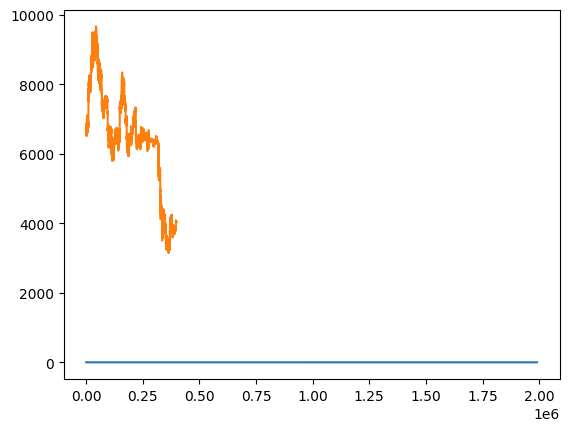

In [10]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling to get actual price predictions
predictions = scaler.inverse_transform(predictions)

# Plot the results
plt.plot(data['Close'].values)
plt.plot(predictions)
plt.show()